# Load and Preprocess Data

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import random_split
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
#read in file
df = pd.read_csv(r"C:\Users\amooney\ORISE\USDA\Python\example_features.csv") 
active_months =["April", "May", "June", "July","August","September"] #choose a subset of months to work with
mask = df['Month'].isin(active_months) #define a mask
reduced_df=df[mask]
reduced_df=reduced_df.reset_index() #reset indices

In [3]:
reduced_df=reduced_df.drop(['index'], axis=1) #drop the redundant index column. 

In [4]:
reduced_df['AVI']=reduced_df['AVI']+reduced_df['EQU']+reduced_df['MOS']+reduced_df['SEN'] #combine all zoo indicators
reduced_df=reduced_df.drop(["EQU", "MOS" , "SEN"],axis=1) #dropping columns that were previously combined
reduced_df=reduced_df.rename(columns={"AVI": "ZOO"}) #rename column to ZOO
grouped_x = reduced_df.groupby(['Year', 'FIPS']).agg({'ZOO':sum, 'PPT': sum,'Temp': max, 'D0': 'mean' , 'D1':'mean', 'D2':'mean',
                                                      'D3':'mean', 'D4':'mean', 'Richness': 'mean', 'Horses': max, 
                                                      's_DEM': 'mean', 's.EstPop': 'mean', 's.Pov_pct': 'mean', 
                                                      's.Med_income':'mean', 'Area.S':max })

In [5]:
#read in non-neuroinvasive WNV data
nn_wnv = pd.read_csv(r"C:\Users\amooney\ORISE\USDA\Python\human_nonneuroinvasive_wnv_1999-2020.csv") 
active_years = [2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019] #choose a subset of years to work with
mask = nn_wnv['Year'].isin(active_years) #define a mask and select the appropriate subset of the df
my_yearnn = nn_wnv[mask]
my_yearnn=my_yearnn.rename(columns={"Year" : "year", "fipscode":"fips"})
grouped_ynn=my_yearnn.groupby(['year', 'fips']).agg({'COUNT':sum}) #group by year and fipscode and aggregate count with sum

In [6]:
#read in neuroinvasive WNV data
n_wnv = pd.read_csv(r"C:\Users\amooney\ORISE\USDA\Python\human_neuroinvasive_wnv_2000-2021.csv")
active_years = [2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019] #choose a subset of years to work with
mask = n_wnv['year'].isin(active_years) #define a mask and select the appropriate subset of the df
my_yearn = n_wnv[mask]
grouped_yn=my_yearn.groupby(['year','fips']).agg({"count":sum}) #group by year and fips
grouped_yn=grouped_yn.reset_index() #resetting indices for neuroinvasive wnv
grouped_ynn=grouped_ynn.reset_index()

In [7]:
merged_y=grouped_yn.merge(grouped_ynn, how='left')

In [8]:
#make a copy of merged_y
copy_y=merged_y.copy()

In [9]:
copy_y=copy_y.fillna(0)

In [10]:
total = copy_y['count'] + copy_y['COUNT']  
merged_y = merged_y.assign(total=total)

In [11]:
#Get X and reset index to compare fips and years 
grouped_x=grouped_x.reset_index()

In [12]:
#make a copy of year and fips columns for merging and comparing
new = grouped_x[['Year', 'FIPS']].copy()

In [13]:
#Rename columns for consistancy
merged_y=merged_y.rename(columns={"fips":"FIPS", "year":"Year", "count":"Count(Yn)", "COUNT":"Count(Ynn)"})

In [14]:
df_all = new.merge(merged_y.drop_duplicates(), on=['Year','FIPS'],
                   how='left', indicator=True)

In [15]:
df_all['_merge'] == 'left_only' 

0        False
1        False
2        False
3        False
4        False
         ...  
55957    False
55958    False
55959    False
55960    False
55961    False
Name: _merge, Length: 55962, dtype: bool

In [16]:
df_all.loc[df_all['_merge'] != 'both'] #all rows in grouped_x that are not in merged_y

,Year,FIPS,Count(Yn),Count(Ynn),total,_merge
2383,2002,46113,NaN,NaN,NaN,left_only
2882,2002,51515,NaN,NaN,NaN,left_only
5492,2003,46113,NaN,NaN,NaN,left_only
5991,2003,51515,NaN,NaN,NaN,left_only
8601,2004,46113,NaN,NaN,NaN,left_only
9100,2004,51515,NaN,NaN,NaN,left_only
11710,2005,46113,NaN,NaN,NaN,left_only
12209,2005,51515,NaN,NaN,NaN,left_only
14819,2006,46113,NaN,NaN,NaN,left_only
15318,2006,51515,NaN,NaN,NaN,left_only


In [17]:
df_all2 = merged_y.merge(new.drop_duplicates(), on=['Year','FIPS'],
                   how='left', indicator=True)

In [18]:
df_all2['_merge'] == 'left_only' 

0        False
1        False
2        False
3        False
4        False
         ...  
55939    False
55940    False
55941    False
55942    False
55943    False
Name: _merge, Length: 55944, dtype: bool

In [19]:
df_all2.loc[df_all2['_merge'] != 'both'] #all rows in merged_y that are not in grouped_x

,Year,FIPS,Count(Yn),Count(Ynn),total,_merge
2378,2002,46102,0,NaN,0.0,left_only
5486,2003,46102,8,19.0,27.0,left_only
8594,2004,46102,0,NaN,0.0,left_only
11702,2005,46102,0,1.0,1.0,left_only
14810,2006,46102,1,NaN,1.0,left_only
17918,2007,46102,2,1.0,3.0,left_only
21026,2008,46102,0,NaN,0.0,left_only
24134,2009,46102,0,NaN,0.0,left_only
27242,2010,46102,0,NaN,0.0,left_only
30350,2011,46102,0,NaN,0.0,left_only


In [20]:
grouped_x.loc[2378, "FIPS"]=46102
grouped_x.loc[5486, "FIPS"]=46102
grouped_x.loc[8594, "FIPS"]=46102
grouped_x.loc[11702, "FIPS"]=46102
grouped_x.loc[14810, "FIPS"]=46102
grouped_x.loc[17918, "FIPS"]=46102
grouped_x.loc[21026, "FIPS"]=46102
grouped_x.loc[24134, "FIPS"]=46102
grouped_x.loc[27242, "FIPS"]=46102
grouped_x.loc[30350, "FIPS"]=46102
grouped_x.loc[33458, "FIPS"]=46102
grouped_x.loc[36566, "FIPS"]=46102
grouped_x.loc[39674, "FIPS"]=46102
grouped_x.loc[42782, "FIPS"]=46102
grouped_x.loc[45890, "FIPS"]=46102
grouped_x.loc[48998, "FIPS"]=46102
grouped_x.loc[52106, "FIPS"]=46102
grouped_x.loc[55214, "FIPS"]=46102

In [21]:
def insert_row(row_num, row_val, df):
    df1=df[0:row_num] #slice upper portion of df
    df2 = df[row_num:] #store lower portion of df for concat later
    df1.loc[row_num]=row_val #insert the new row in the upper half at row_num
    new_df = pd.concat([df1,df2]) #concat df1 and df2
    new_df.index = [*range(new_df.shape[0])] #reassign index labels
    return new_df

In [22]:
add_list=merged_y.index[merged_y['FIPS'] == 51510].tolist()

In [23]:
year_list=[2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
for i in range(len(year_list)):
    row_val=[year_list[i],'51515','NaN','NaN','0']
    inter_df=insert_row(add_list[i],row_val, merged_y)
    merged_y=inter_df
print(merged_y.shape)

<ipython-input-21-ba103c7c30f2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[row_num]=row_val #insert the new row in the upper half at row_num
<ipython-input-21-ba103c7c30f2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[row_num]=row_val #insert the new row in the upper half at row_num
<ipython-input-21-ba103c7c30f2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[row_num]=row_val #insert the new row in 

(55962, 5)


<ipython-input-21-ba103c7c30f2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[row_num]=row_val #insert the new row in the upper half at row_num
<ipython-input-21-ba103c7c30f2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[row_num]=row_val #insert the new row in the upper half at row_num
<ipython-input-21-ba103c7c30f2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[row_num]=row_val #insert the new row in 

In [24]:
df_check = grouped_x.merge(merged_y.drop_duplicates(), on=['Year','FIPS'],
                   how='left', indicator=True)

In [25]:
df_check['_merge'] == 'left_only' 

0        False
1        False
2        False
3        False
4        False
         ...  
55957    False
55958    False
55959    False
55960    False
55961    False
Name: _merge, Length: 55962, dtype: bool

In [26]:
df_all2.loc[df_all2['_merge'] != 'both'] 

,Year,FIPS,Count(Yn),Count(Ynn),total,_merge
2378,2002,46102,0,NaN,0.0,left_only
5486,2003,46102,8,19.0,27.0,left_only
8594,2004,46102,0,NaN,0.0,left_only
11702,2005,46102,0,1.0,1.0,left_only
14810,2006,46102,1,NaN,1.0,left_only
17918,2007,46102,2,1.0,3.0,left_only
21026,2008,46102,0,NaN,0.0,left_only
24134,2009,46102,0,NaN,0.0,left_only
27242,2010,46102,0,NaN,0.0,left_only
30350,2011,46102,0,NaN,0.0,left_only


In [27]:
df_check2 = merged_y.merge(grouped_x.drop_duplicates(), on=['Year','FIPS'],
                   how='left', indicator=True)

In [28]:
df_check['_merge'] == 'left_only' 

0        False
1        False
2        False
3        False
4        False
         ...  
55957    False
55958    False
55959    False
55960    False
55961    False
Name: _merge, Length: 55962, dtype: bool

In [29]:
df_all2.loc[df_all2['_merge'] != 'both'] 

,Year,FIPS,Count(Yn),Count(Ynn),total,_merge
2378,2002,46102,0,NaN,0.0,left_only
5486,2003,46102,8,19.0,27.0,left_only
8594,2004,46102,0,NaN,0.0,left_only
11702,2005,46102,0,1.0,1.0,left_only
14810,2006,46102,1,NaN,1.0,left_only
17918,2007,46102,2,1.0,3.0,left_only
21026,2008,46102,0,NaN,0.0,left_only
24134,2009,46102,0,NaN,0.0,left_only
27242,2010,46102,0,NaN,0.0,left_only
30350,2011,46102,0,NaN,0.0,left_only


In [30]:
y=merged_y

In [31]:
#Extract the "total" column from y
bin_y=y.iloc[:,4]

In [32]:
bin_y=pd.DataFrame(bin_y)

In [33]:
bin_y[bin_y != 0] = 1

In [34]:
bin_y['total']=bin_y['total'].apply(np.int64)

In [35]:
scaler=MinMaxScaler()
scaled_x=scaler.fit_transform(grouped_x)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(scaled_x, bin_y , 
                                   random_state=0,  
                                   test_size=0.20,  
                                   shuffle=True)

In [37]:
from tensorflow import keras
from tensorflow.keras import layers

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))  # Replace input_dim with your input dimension

    # Tune the number of units in the first Dense layer
    model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'))
    
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))

    # Tune the number of layers and units in subsequent Dense layers
    for _ in range(hp.Int('num_layers', min_value=1, max_value=5)):
        model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.add(layers.Dense(1, activation='hard_sigmoid'))  # Replace output_dim with your output dimension
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

    return model

In [38]:
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to train and evaluate for each trial
    directory='my_tuner_dir',  # Directory to store tuning results
    project_name='my_tuning_project'  # Name of the tuning project
)

<ipython-input-38-07748c4bb31a>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Reloading Tuner from my_tuner_dir\my_tuning_project\tuner0.json


In [39]:
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

In [40]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [41]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

350/350 [==============================] - 2s 3ms/step - loss: 0.1113 - accuracy: 0.8538
Test Accuracy: 0.8538371920585632


350/350 [==============================] - 1s 3ms/step
[[9019    9]
 [1979  186]]


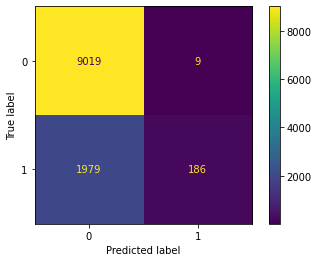

In [42]:
predictions = best_model.predict(X_test).astype(int)
y_pred=(predictions > 0.5)
cm= confusion_matrix(y_test, y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()